# LAB 02: TIME SERIES ANALYSIS
### Nhóm thực hiện: Nhóm 08 - CQ2022/21

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Code to ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Bước 1: Import tập dữ liệu

In [4]:
df = pd.read_csv('./train.csv')
df.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


Thông tin chung của tập dữ liệu

In [5]:
df.describe() 

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

### Bước 2: Tiền xử lý dữ liệu

Loại bỏ cột Row ID vì nó không cần thiết

In [7]:
df.drop('Row ID',axis = 1, inplace = True)

Parse Order Date thành kiểu datetime và set index cho cột Order Date

In [8]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
print('Order Date Description\n') 
print(df['Order Date'].describe())
df.set_index("Order Date", inplace = True)

Order Date Description

count                             9800
mean     2017-05-01 05:13:51.673469440
min                2015-01-03 00:00:00
25%                2016-05-24 00:00:00
50%                2017-06-26 00:00:00
75%                2018-05-15 00:00:00
max                2018-12-30 00:00:00
Name: Order Date, dtype: object


Kiểm tra những dòng dữ liệu thiếu và fill dòng trống với giá trị 0

In [9]:
if df.isnull().values.any():
    df.fillna(0, inplace=True)

Tính tổng cột Sales (doanh số) theo tháng

In [10]:
monthly_sales = df.resample('M').sum()['Sales']

### Step 3: Visualize dữ liệu

Visulize dữ liệu vừa xử lý dưới dạng tổng doanh thu theo tháng

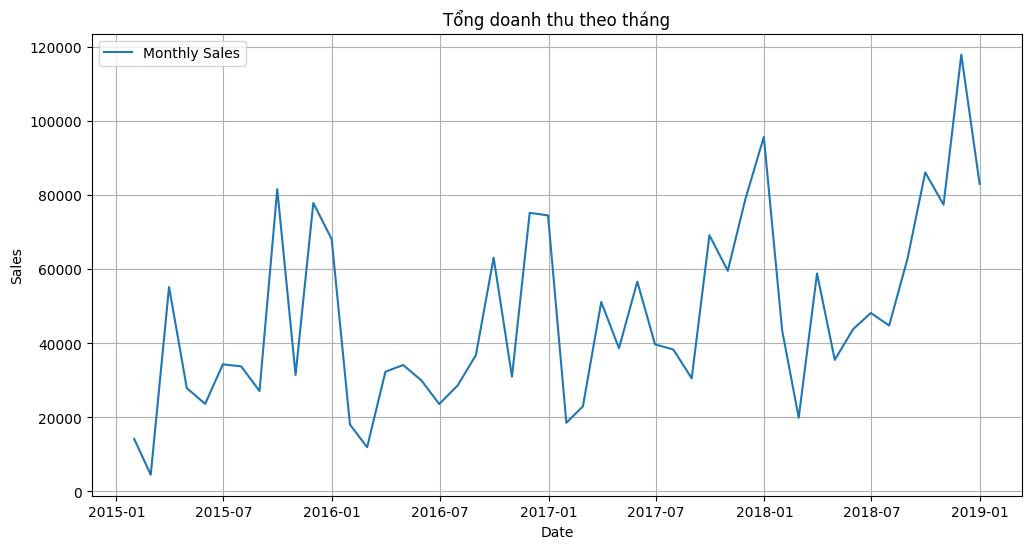

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Monthly Sales')
plt.title('Tổng doanh thu theo tháng')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

__Kết luận__: 
* Nhìn vào biểu đồ trên, ta thấy doanh thu của siêu thị này có xu hướng tăng nhẹ theo thời gian (01-2015 đến 12-2018), đồng thời doanh thu sẽ cao ở đầu năm và sụt giảm ở giữa năm và tăng mạnh vào các tháng cuối năm. Mô hình này được lặp lại tương đối giống nhau ở các năm.
* Để lý giải cho việc tăng này, ta có thể hiểu vào dịp cuối năm có nhiều ngày lễ như Black Friday, Giáng sinh, Tết Dương Lịch, người dân có xu hướng mua sắm, tiêu dùng nhiều hơn vào những dịp này. Nên doanh thu sẽ tăng.
<br>
<br>
__Vậy ta sẽ mong đợi khi kết quả dự đoán cũng có xu hướng giống với dữ liệu hiện tại__

### Bước 4: Kiểm tra tính dừng

**Kiểm định Augmented Dicky Fuller**
* Kiểm định Augmented Dickey-Fuller là một loại kiểm định thống kê còn được gọi là kiểm định đơn vị. Nền tảng của kiểm định đơn vị là giúp xác định mức độ mà một chuỗi thời gian được xác định bởi xu hướng (trend). 
* Giả thuyết gốc của kiểm định là chuỗi thời gian có thể được biểu diễn bởi một đơn vị root, tức là nó không dừng. Giả thuyết thay thế (bác bỏ giả thuyết gốc) là chuỗi thời gian dừng.

    1. Giả thuyết gốc (H0): Chuỗi thời gian không dừng.
    2. Giả thuyết thay thế (H1): Chuỗi thời gian dừng.
* Kết quả được diễn giải dựa trên giá trị p (p-value) từ kiểm định.

    1. p-value > 0.05: Không bác bỏ giả thuyết gốc (H0), dữ liệu có đơn vị root và không dừng.
    2. p-value <= 0.05: Bác bỏ giả thuyết gốc (H0), dữ liệu không có căn đơn vị và là dừng.

In [12]:
from statsmodels.tsa.stattools import adfuller #importing adfuller tool from statsmodels

adf = adfuller(monthly_sales)

print(adf)
print('\nADF = ', str(adf[0])) #more towards negative value the better
print('\np-value = ', str(adf[1]))
print('\nCritical Values: ')

for key, val in adf[4].items(): #for loop to print the p-value (1%, 5% and 10%) and their respective values
    print(key,':',val)
    

    if adf[0] < val:
        print('Null Hypothesis Rejected. Time Series is Stationary')
    else:
        print('Null Hypothesis Accepted. Time Series is not Stationary')

(np.float64(-4.416136761430769), np.float64(0.00027791039276670623), 0, 47, {'1%': np.float64(-3.5778480370438146), '5%': np.float64(-2.925338105429433), '10%': np.float64(-2.6007735310095064)}, np.float64(847.3050446881931))

ADF =  -4.416136761430769

p-value =  0.00027791039276670623

Critical Values: 
1% : -3.5778480370438146
Null Hypothesis Rejected. Time Series is Stationary
5% : -2.925338105429433
Null Hypothesis Rejected. Time Series is Stationary
10% : -2.6007735310095064
Null Hypothesis Rejected. Time Series is Stationary


Biểu diễn seasonal decomposition của chuỗi thời gian để tách thành 3 thành phần chính: trend, seasonality, và residuals

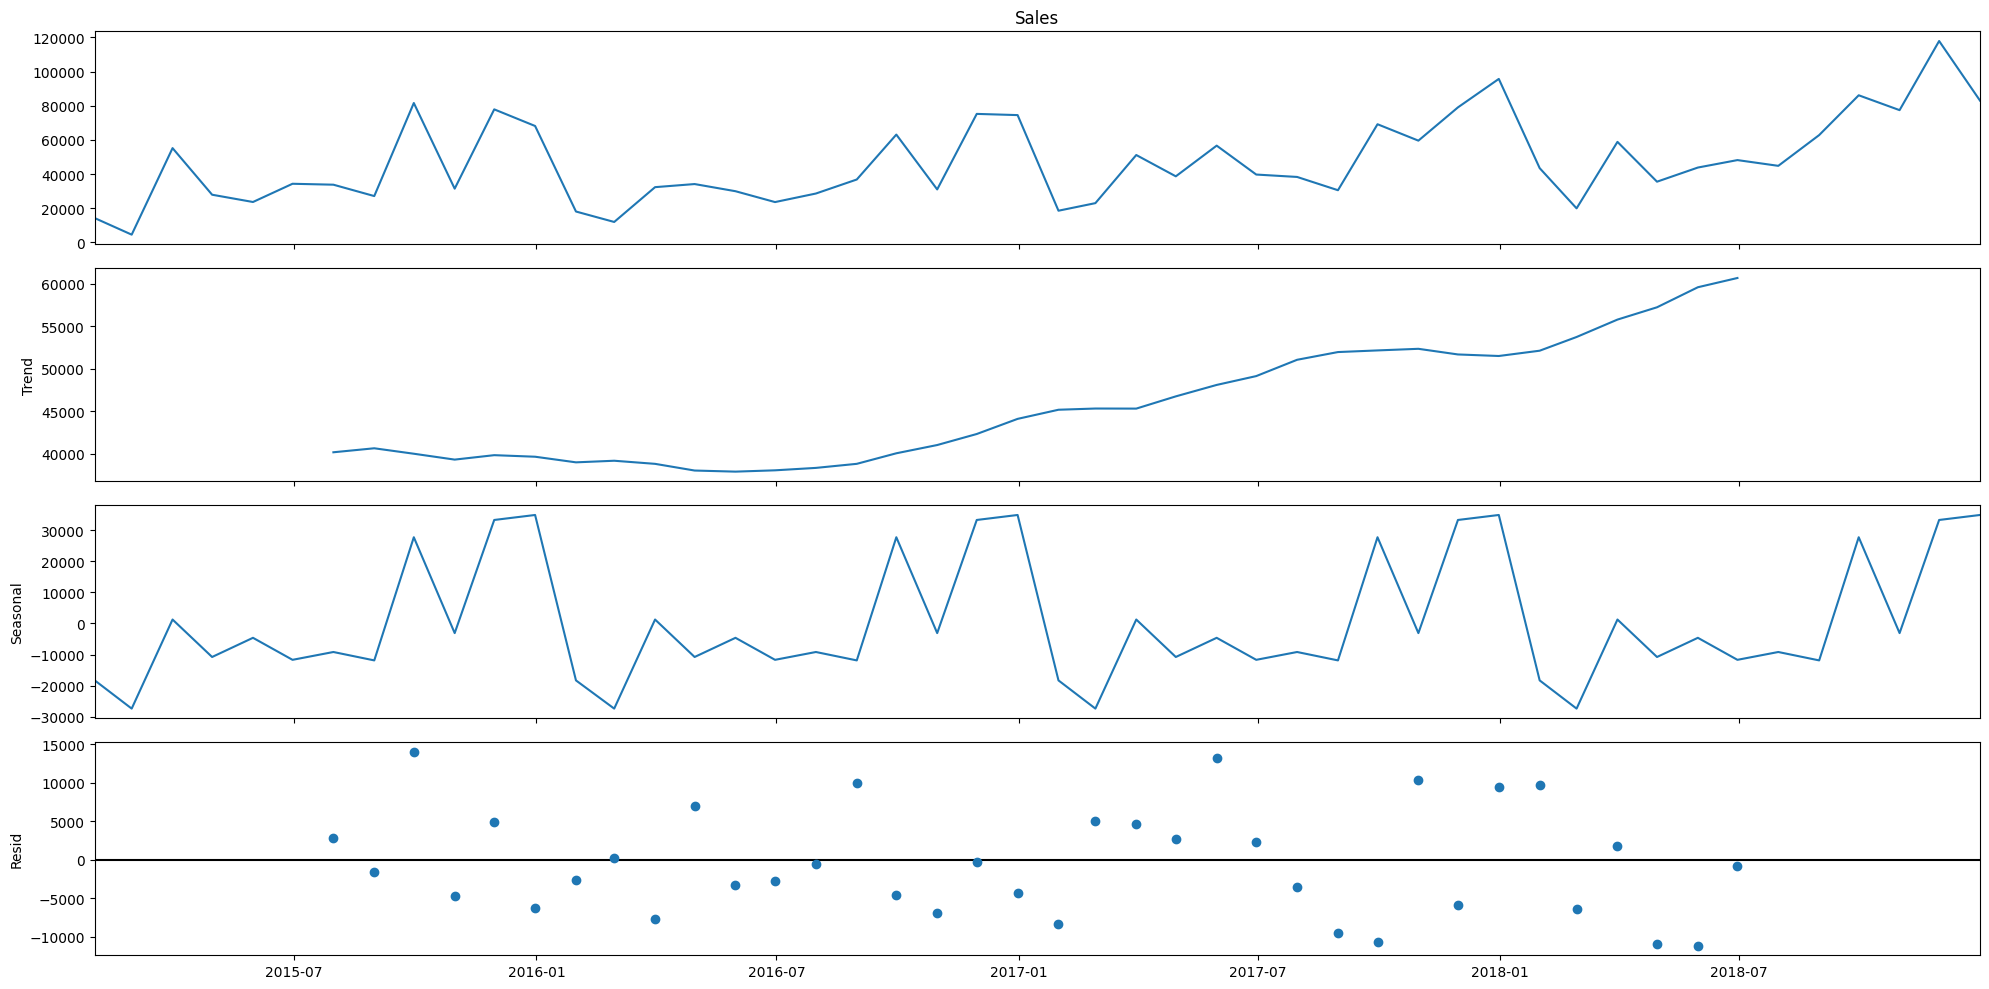

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(monthly_sales, model='additive')
fig = decomposition.plot()
plt.show()

### Bước 5: Huấn luyện mô hình SARIMA

## __Mô hình SARIMA__

Seasonal Autoregressive Integrated Moving Average (SARIMA), hay còn gọi là Seasonal ARIMA, là một mở rộng của mô hình ARIMA hỗ trợ dữ liệu chuỗi thời gian đơn biến có thành phần season.

SARIMA yêu cầu xác định các siêu tham số cho cả thành phần xu hướng và thành phần seasonal của chuỗi thời gian.

1. Có ba thành phần xu hướng cần được đảm bảo <br>
p: Bậc tự hồi quy của xu hướng (Trend autoregression order). d: Bậc sai phân của xu hướng (Trend difference order). q: Bậc trung bình trượt của xu hướng (Trend moving average order).

2. Thành phần mùa vụ (Seasonal Elements) 
Có bốn thành phần mùa vụ:
    * P: Bậc tự hồi quy của mùa vụ (Seasonal autoregressive order). <br> 
    * D: Bậc sai phân của mùa vụ (Seasonal difference order). 
    * Q: Bậc trung bình trượt của mùa vụ (Seasonal moving average order). 
    * m: Số bước thời gian trong một chu kỳ mùa vụ (The number of time steps for a single seasonal period).

### Ký hiệu mô hình SARIMA
Mô hình SARIMA được ký hiệu dưới dạng:
SARIMA(p,d,q)(P,D,Q)m

In [14]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
print(f"p, d, q combinations: {pdq}")
seasonal_pdq_comb = [(i[0], i[1], i[2], 12) for i in pdq] #for loop for creating combinations of seasonal parameters of SARIMA
print('Examples of parameter combinations for Seasonal ARIMA:')
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq_comb[1]))
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq_comb[2]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq_comb[3]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq_comb[4]))

p, d, q combinations: [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
Examples of parameter combinations for Seasonal ARIMA:
SARIMA: (0, 0, 1) x (0, 0, 1, 12)
SARIMA: (0, 0, 1) x (0, 1, 0, 12)
SARIMA: (0, 1, 0) x (0, 1, 1, 12)
SARIMA: (0, 1, 0) x (1, 0, 0, 12)


__Xác định tổ hợp tham số season tốt nhất cho mô hình SARIMA__

Tổ hợp tốt nhất cho mô hình SARIMA nên có giá trị AIC nhỏ nhất.

* Akaike Information Criterion (AIC) là một ước lượng của lỗi dự đoán ngoài mẫu và qua đó đánh giá chất lượng tương đối của các mô hình thống kê đối với một tập dữ liệu nhất định. AIC ước tính lượng thông tin bị mất tương đối bởi một mô hình cụ thể. Mô hình mất càng ít thông tin thì chất lượng của nó càng cao.
* Vì vậy, chúng ta nên chọn tổ hợp tham số có giá trị AIC nhỏ nhất.

In [15]:
for parameters in pdq:
    for seasonal_param in seasonal_pdq_comb:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_sales,
                                            order=parameters,
                                            seasonal_param_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False) #determines the AIC value of the model**
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(parameters, seasonal_param, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1159.2085910103256
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1159.2085910103256
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1159.2085910103256
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1159.2085910103256
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1159.2085910103256
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1159.2085910103256
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1159.2085910103256
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1159.2085910103256
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1113.8437617516495
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1113.8437617516495
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1113.8437617516495
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1113.8437617516495
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1113.8437617516495
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1113.8437617516495
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1113.8437617516495
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1113.8437617516495
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1072.3494830309144
SARIMA(0, 1, 0)x(0, 0, 1, 12)12

Chúng ta sẽ chọn mô hình SARIMA(1, 1, 1)x(1, 1, 1, 12)12 vì nó có giá trị AIC nhỏ nhất.
<br>
Bây giờ, chúng ta sẽ tiến hành huấn luyện mô hình trên dữ liệu.

In [16]:
mod = sm.tsa.statespace.SARIMAX(monthly_sales,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12)) #model defintion
results = mod.fit(disp=False) #model fitting

### Bước 6: Đánh giá model

In [17]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -383.926
Date:                            Sun, 01 Dec 2024   AIC                            777.851
Time:                                    21:49:45   BIC                            785.628
Sample:                                01-31-2015   HQIC                           780.536
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5094      0.234      2.179      0.029       0.051       0.968
ma.L1         -0.9007      0.185   

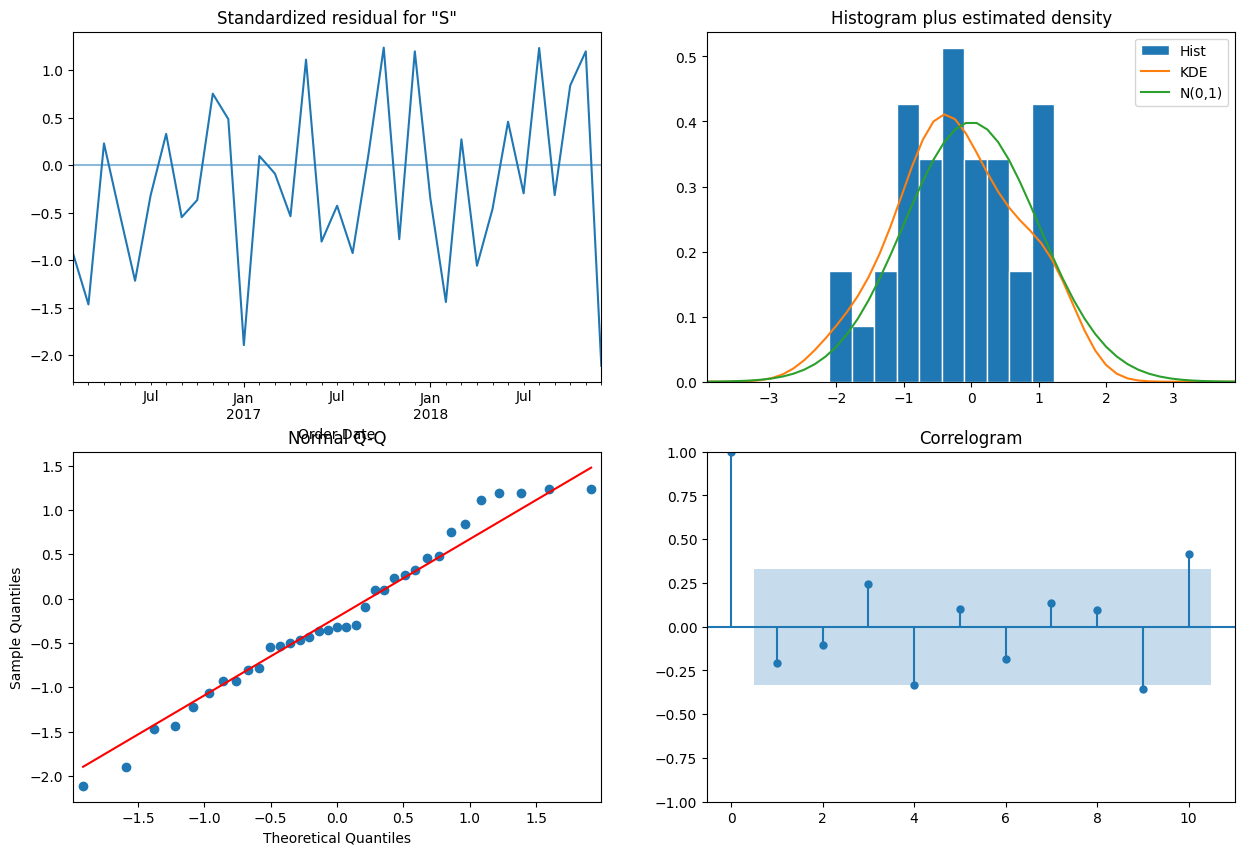

In [18]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

### Bước 7: Thực hiện dự đoán

Dự đoán tổng doanh thu cho 12 tháng tiếp theo

In [19]:
forecast = results.get_forecast(steps=12)  # Forecast the next 12 months
forecast_index = pd.date_range(start=monthly_sales.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

Lấy khoảng tin cậy.

In [20]:
conf_int = forecast.conf_int()

Trực quan hóa dự đoán

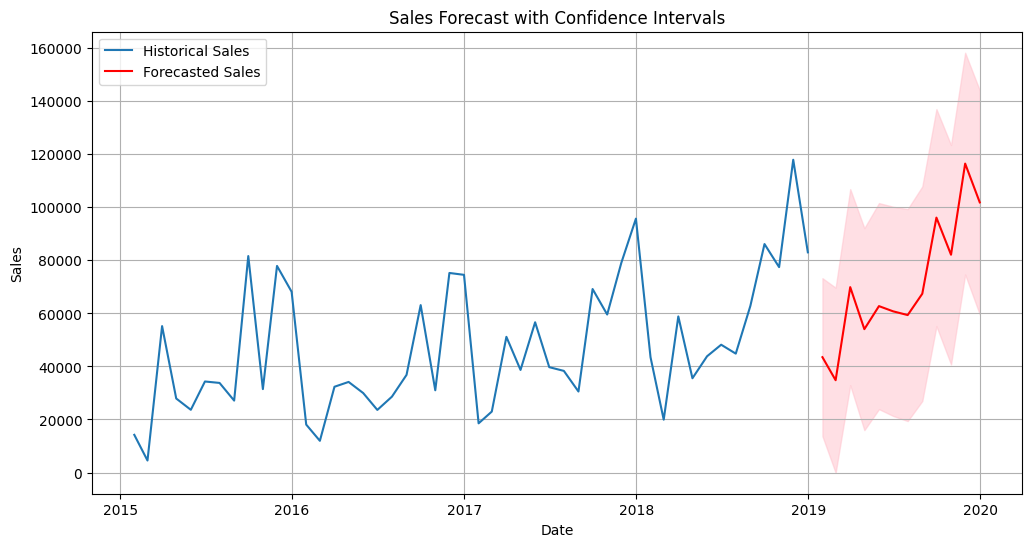

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Historical Sales')
plt.plot(forecast_series, label='Forecasted Sales', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.5)
plt.title('Sales Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

Nhìn vào biểu đồ dự doán 12 tháng kế tiếp, ta thấy doanh thu trong năm 2019 cũng tương tự như các năm trước. Do đó có thể nói dự đoán của chúng ta là tương đối chính xác.